# Circular loop antenna
In this notebook, a resonant loop antenna is modeled using the thin-wire MoM implementation.
 - Input impedance versus frequency
 - Far-field radiation pattern

In [1]:
using CairoMakie
using TimerOutputs

include("../src/Mesh.jl")
include("../src/Sources.jl")
include("../src/Matrix.jl")
include("../src/PostProcessing.jl")
include("../src/Visualization.jl")

plot_mesh (generic function with 1 method)

In [2]:
ε = 8.854e-12      # Vacuum permittivity [F/m]
μ = 4e-7 * π       # Vacuum permeability [H/m]

c = 1 / √(μ * ε)   # Speed of light in vacuum [m/s]
η = √(μ / ε)       # Impedance of vacuum [Ω]

376.73430918211017

# Generate mesh

In [3]:
Nel = 34
x = [0 0 0]
R = 0.3474
a = 1e-3

nodes, edges = mesh_loop(x, R, Nel, 1)
end_points = get_end_points(nodes, edges)
basis_vecs = assign_basis_vector(nodes, edges)

msh = Mesh(nodes, edges, end_points, basis_vecs, a)

Mesh([0.3474 0.0 0.0; 0.3411220294290643 0.0657458822908065 0.0; … ; 0.3411220294290643 -0.06574588229080665 0.0; 0.3474 -8.508845960475809e-17 0.0], [[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]  …  [25, 26], [26, 27], [27, 28], [28, 29], [29, 30], [30, 31], [31, 32], [32, 33], [33, 34], [34, 1]], Int64[], [0.09505604330418292 -0.9954719225730845 0.0; 0.28173255684142956 -0.9594929736144971 0.0; … ; -0.09505604330418285 -0.9954719225730847 0.0; 0.0 -0.9999999999999998 0.0], 0.001)

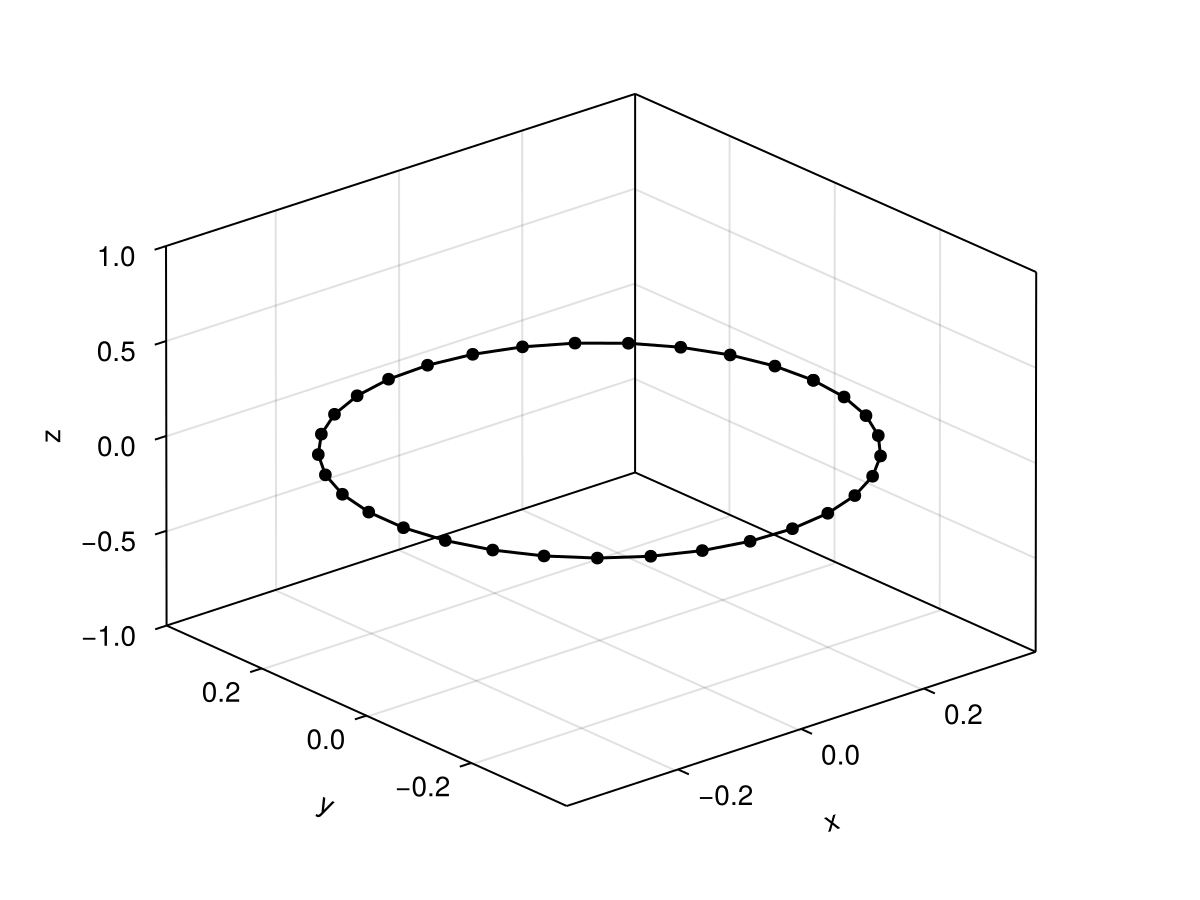

In [4]:
# Plot the antenna in 3D
f_msh = plot_mesh(msh)
f_msh

# Sources
The antenna is fed in the middle by a delta-gap voltage source $V_{in}$.

In [5]:
# Mid-point feed
Vin = 1
idx_mid = Integer(floor(Nel / 2)) # Index of center element
src1 = VoltageSource(Vin, idx_mid)

src = [src1]

1-element Vector{VoltageSource}:
 VoltageSource(1, 17)

# Frequency sweep
Next, we can solve the current distribution for a range of frequencies and plot the input impedance vs frequency.

In [13]:
# Input impedance frequency sweep
frequencies = range(30e6, 300e6, 100)
Zin = zeros(Complex{Float64}, length(frequencies))

reset_timer!()

@timeit "frequency sweep" for (i, f) ∈ enumerate(frequencies)
    # Assemble system equations
    @timeit "assembly" Z, V = assemble_global(msh, src, f, μ, ε)

    # Solve system
    @timeit "solve" Isol = Z \ V

    # Calculate input impedance
    e = msh.edges[src[1].edge]
    Iin = sum(Isol[e]) / length(Isol[e])
    Zin[i] = Vin / Iin
end

print_timer()

─────────────────────────────────────────────────────────────────────────────
                                    Time                    Allocations      
                           ───────────────────────   ────────────────────────
     Tot / % measured:          565ms /  69.3%            411MiB /  99.6%    

Section            ncalls     time    %tot     avg     alloc    %tot      avg
─────────────────────────────────────────────────────────────────────────────
frequency sweep         1    392ms  100.0%   392ms    409MiB  100.0%   409MiB
  assembly            100    380ms   96.9%  3.80ms    408MiB   99.5%  4.08MiB
    outer loop        100    378ms   96.4%  3.78ms    404MiB   98.7%  4.04MiB
      inner loop    3.40k    375ms   95.7%   110μs    401MiB   97.9%   121KiB
        element      116k    328ms   83.6%  2.83μs    337MiB   82.4%  2.99KiB
      source        3.40k   1.88ms    0.5%   552ns   3.32MiB    0.8%  1.00KiB
  solve               100   11.1ms    2.8%   111μs   1.86MiB   

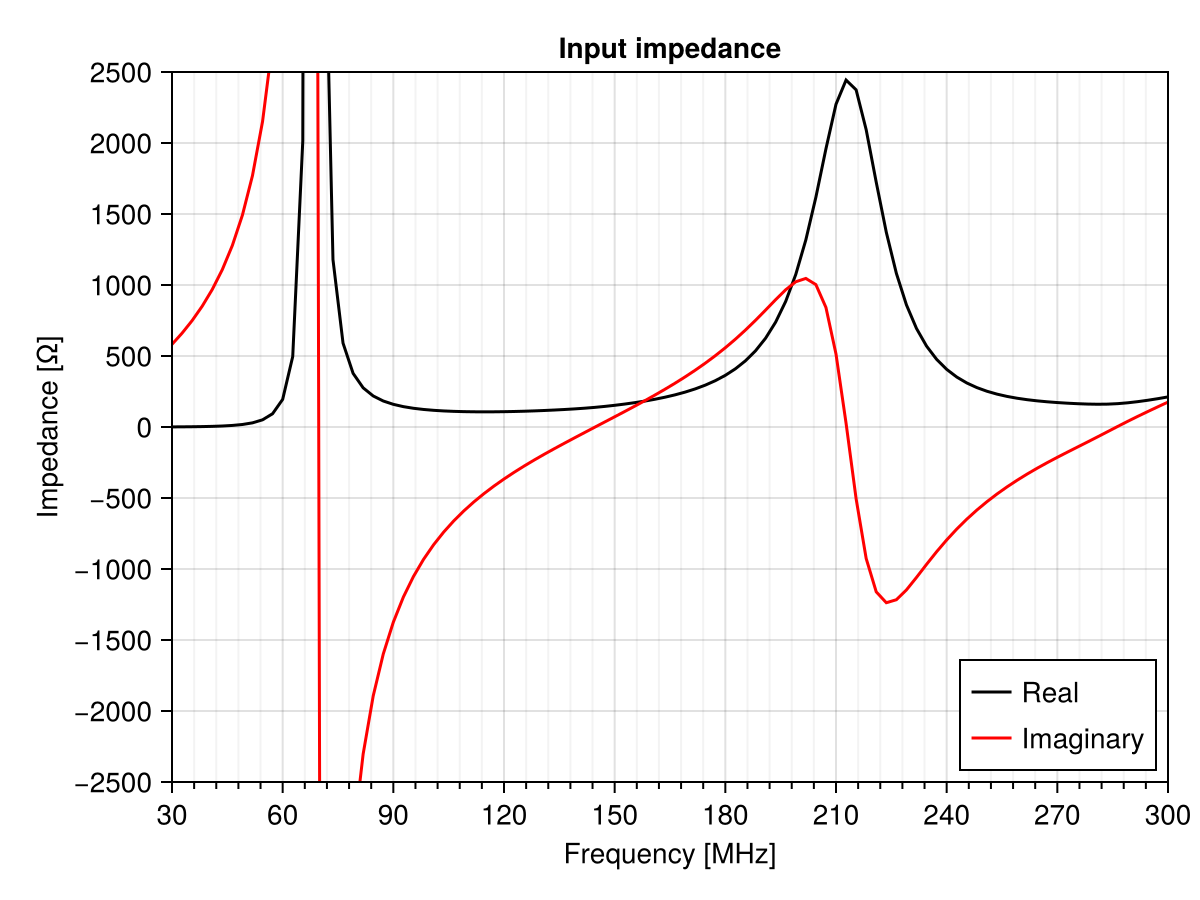

In [7]:
fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel="Frequency [MHz]", ylabel="Impedance [Ω]", title="Input impedance",
    limits=(30, 300, -2500, 2500),
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5),
    yticks=-2500:500:2500
)

lines!(ax, frequencies * 1e-6, real.(Zin), color=:black, label="Real")
lines!(ax, frequencies * 1e-6, imag.(Zin), color=:red, label="Imaginary")
axislegend(position = :rb)

fig

# Far-field radiation pattern
The far-field radiation pattern is calculated using the far-field approximation at a distance of $100 \lambda$ from the antenna.

In [8]:
f = 144e6

# Solve currents
Z, V = assemble_global(msh, src, f, μ, ε)
Isol = Z \ V

# Calculate input impedance
e = msh.edges[src[1].edge]
Iin = sum(Isol[e]) / length(Isol[e])
Zin = Vin / Iin

reset_timer!()

# Calculate far field E-field
R = 100 * (c / f)       # Radius of evaluation points
N = 100                 # Number of evaluation points
θs = range(0, 2π, N)    # Evaluation angles

coords_xy = zeros(N, 3)
coords_xz = zeros(N, 3)
for (i, θ) ∈ enumerate(θs)
    coords_xy[i, :] = [(R * cos(θ)) (R * sin(θ)) 0]
    coords_xz[i, :] = [(R * cos(θ)) 0 (R * sin(θ))]
end

@timeit "FarField - xy" Exy = CalcFarField(msh, Isol, coords_xy, f, μ, ε);
@timeit "FarField - xz" Exz = CalcFarField(msh, Isol, coords_xz, f, μ, ε);

Pavg = Vin^2 / real(Zin) / (4π * R^2) # Power density of isotropic radiator

Pxy = norm.(eachrow(Exy)).^2 / η
Pxz = norm.(eachrow(Exz)).^2 / η

print_timer()

────────────────────────────────────────────────────────────────────────────────
                                       Time                    Allocations      
                              ───────────────────────   ────────────────────────
      Tot / % measured:            2.37s /  79.5%            406MiB /  87.7%    

Section               ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────────
FarField - xy              1    1.88s   99.9%   1.88s    350MiB   98.3%   350MiB
  evaluation loop          1   3.00ms    0.2%  3.00ms   6.06MiB    1.7%  6.06MiB
    loop over edges      100   2.93ms    0.2%  29.3μs   5.86MiB    1.6%  60.0KiB
FarField - xz              1   2.66ms    0.1%  2.66ms   6.06MiB    1.7%  6.06MiB
  evaluation loop          1   2.65ms    0.1%  2.65ms   6.06MiB    1.7%  6.06MiB
    loop over edges      100   2.60ms    0.1%  26.0μs   5.86MiB    1.6%  60.0KiB
───────────────────────────

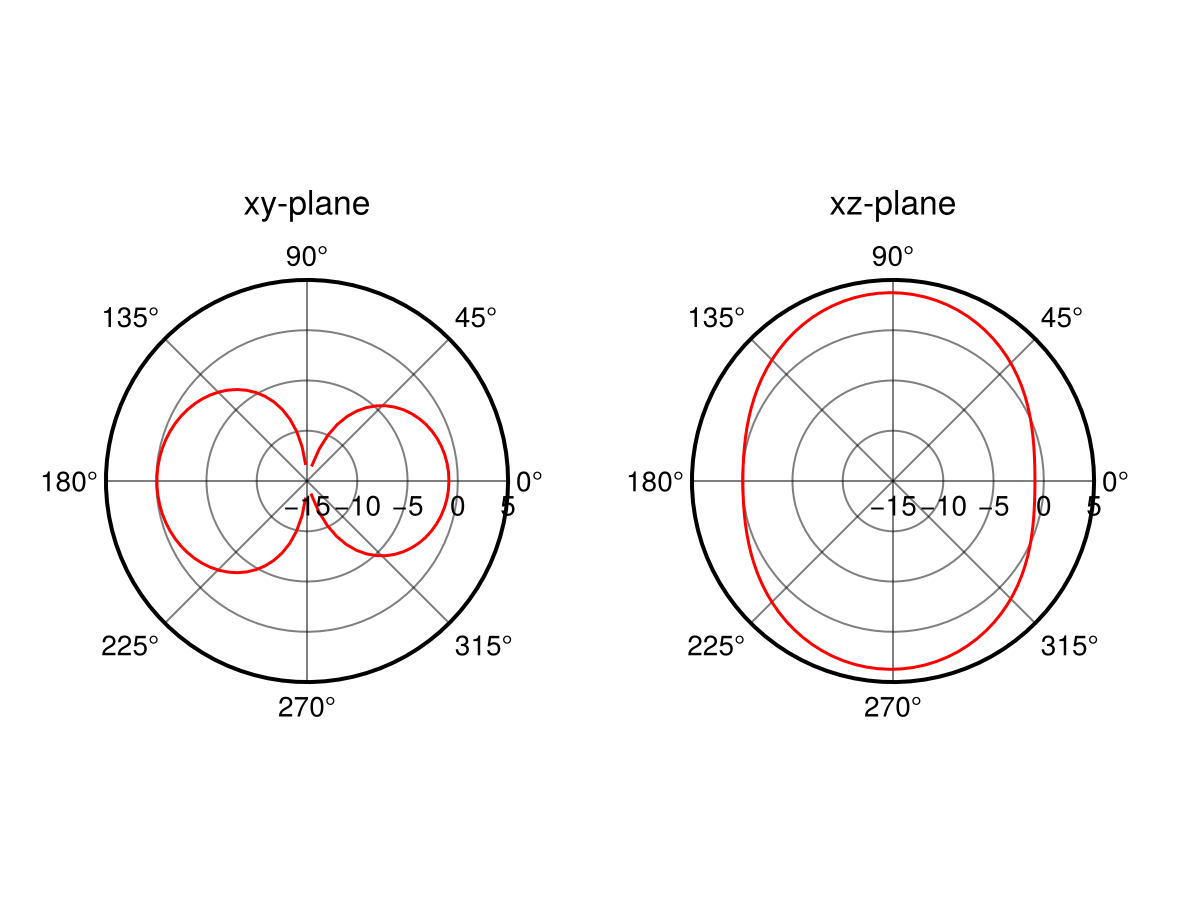

In [9]:
fig = Figure()

ax = PolarAxis(fig[1,1], rlimits = (-15, 5), radius_at_origin = -15, title = "xy-plane")
lines!(ax, θs, 10 * log10.(Pxy / Pavg), color = :red)

ax = PolarAxis(fig[1,2], rlimits = (-15, 5), radius_at_origin = -15, title = "xz-plane")
lines!(ax, θs, 10 * log10.(Pxz / Pavg), color = :red)

fig

In [10]:
θ = 180π / 180
Efront = CalcFarField(msh, Isol, [0 0 R], f, μ, ε);
Eside = CalcFarField(msh, Isol, [R * cos(θ) 0 R * sin(θ)], f, μ, ε);

Pfront = norm(Efront)^2 / η
Pside = norm(Eside)^2 / η

# Calculate the front-to-side ratio in dB
# Result from EZNEC: 3.75 dB
Rfs = 10 * log10(Pfront / Pside)

3.7958703969480334